In [ ]:
# --- Environment Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import zipfile
from urllib.parse import urlparse
from tld import get_tld
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import joblib  # For model saving/loading
import warnings
warnings.filterwarnings('ignore')

# Set global seed for reproducibility
SEED = 42
np.random.seed(SEED)

# --- Enhanced Feature Extraction ---
class URLFeatureExtractor:
    @staticmethod
    def having_ip_address(url):
        ip_pattern = re.compile(
            r'(\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b)|'
            r'(::\d{1,3})|'  # Simplified IPv6 pattern
            r'([0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}'
        )
        return 1 if ip_pattern.search(url) else 0

    @staticmethod
    def count_subdomains(url):
        parsed = urlparse(url)
        if parsed.netloc:
            return parsed.netloc.count('.')
        return 0

    @staticmethod
    def url_entropy(url):
        from math import log2
        prob = [float(url.count(c)) / len(url) for c in set(url)]
        return -sum(p * log2(p) for p in prob)

    @staticmethod
    def extract_features(url):
        try:
            parsed = urlparse(url)
            features = {}

            # Basic features
            features['use_of_ip'] = URLFeatureExtractor.having_ip_address(url)
            features['count.'] = url.count('.')
            features['count-www'] = url.count('www')
            features['count@'] = url.count('@')
            features['count_dir'] = url.count('/')
            features['count_embed'] = url.count('//')
            features['short_url'] = 1 if any(s in url for s in [
                'bit.ly', 'goo.gl', 'tinyurl', 'ow.ly', 't.co'
            ]) else 0
            features['count-https'] = url.count('https')
            features['count-http'] = url.count('http')
            features['count%'] = url.count('%')
            features['count?'] = url.count('?')
            features['count-'] = url.count('-')
            features['count='] = url.count('=')
            features['url_length'] = len(url)
            features['hostname_length'] = len(parsed.netloc) if parsed.netloc else 0
            features['sus_words'] = 1 if re.search(
                r'login|signin|bank|account|update|free|secure|ebayisapi|webscr',
                url, re.I
            ) else 0
            features['fd_length'] = len(parsed.path.split('/')[1]) if len(parsed.path.split('/')) > 1 else 0
            features['tld'] = get_tld(url, fail_silently=True, as_object=True).domain if get_tld(url, fail_silently=True) else ''

            # Advanced features
            features['subdomain_count'] = URLFeatureExtractor.count_subdomains(url)
            features['entropy'] = URLFeatureExtractor.url_entropy(url)
            features['digit_count'] = sum(c.isdigit() for c in url)
            features['letter_count'] = sum(c.isalpha() for c in url)
            features['symbol_count'] = len(url) - (features['digit_count'] + features['letter_count'])

            return pd.DataFrame([features])

        except Exception as e:
            print(f"Error processing {url}: {str(e)}")
            return pd.DataFrame()

# --- Model Training with Enhanced Features ---
def train_model():
    # Load and preprocess data
    df = pd.read_csv('malicious_phish.csv')
    df = df[['url', 'type']].drop_duplicates().dropna()

    # Feature extraction
    feature_df = pd.concat([URLFeatureExtractor.extract_features(url) for url in df.url], ignore_index=True)
    final_df = pd.concat([df.reset_index(drop=True), feature_df], axis=1)

    # Label encoding
    le = LabelEncoder()
    final_df['label'] = le.fit_transform(final_df['type'])

    # Handle class imbalance
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(final_df['label']),
        y=final_df['label']
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Train/test split
    X = final_df.drop(['url', 'type', 'label'], axis=1)
    y = final_df['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=SEED
    )

    # Train Random Forest with class weights
    rf = RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        class_weight=weight_dict,
        random_state=SEED,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # Evaluate
    y_pred = rf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    joblib.dump(rf, 'url_classifier.pkl')
    joblib.dump(le, 'label_encoder.pkl')

    return rf, le

# --- Prediction System ---
class URLClassifier:
    def __init__(self):
        self.model = joblib.load('url_classifier.pkl')
        self.le = joblib.load('label_encoder.pkl')
        self.feature_columns = [
            'use_of_ip', 'count.', 'count-www', 'count@', 'count_dir',
            'count_embed', 'short_url', 'count-https', 'count-http',
            'count%', 'count?', 'count-', 'count=', 'url_length',
            'hostname_length', 'sus_words', 'fd_length', 'subdomain_count',
            'entropy', 'digit_count', 'letter_count', 'symbol_count'
        ]

    def predict(self, url):
        features = URLFeatureExtractor.extract_features(url)
        if not features.empty:
            features = features[self.feature_columns].fillna(0)
            pred = self.model.predict(features)
            return self.le.inverse_transform(pred)[0]
        return "UNKNOWN"

full_df = pd.read_csv('/new_data_urls.csv')

In [ ]:
pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
# --- Environment Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import zipfile
from urllib.parse import urlparse
from tld import get_tld
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import joblib  # For model saving/loading
import warnings
warnings.filterwarnings('ignore')

# Set global seed for reproducibility
SEED = 42
np.random.seed(SEED)

# --- Enhanced Feature Extraction ---
class URLFeatureExtractor:
    # ... (rest of the code remains the same) ...

    @staticmethod
    def extract_features(url):
        try:
            # ... (rest of the code remains the same) ...

            # Basic features
            # ... (rest of the code remains the same) ...
            # Change this line to handle empty tld
            features['tld'] = get_tld(url, fail_silently=True, as_object=True).domain if get_tld(url, fail_silently=True) else 'unknown'

            # Advanced features
            # ... (rest of the code remains the same) ...

            return pd.DataFrame([features])

        except Exception as e:
            print(f"Error processing {url}: {str(e)}")
            return pd.DataFrame()

#

URL: http://www.google.com
Prediction: phishing

URL: https://www.paypal-login.secure.com/update?account=123
Prediction: phishing

URL: http://192.168.1.1:8080/path?query=1
Prediction: malware

URL: https://www.legitsite.co.za
Prediction: phishing



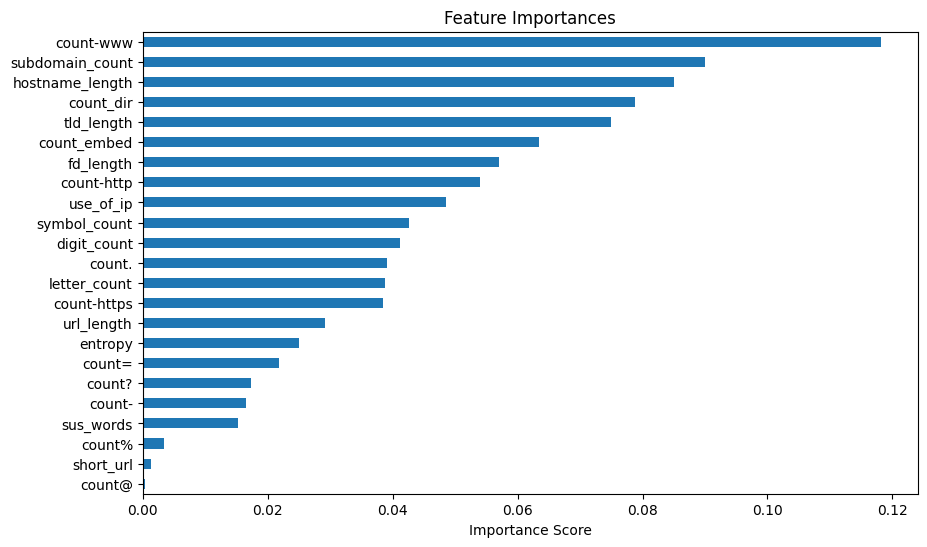

In [ ]:
# --- Environment Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import zipfile
from urllib.parse import urlparse
from tld import get_tld
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import joblib  # For model saving/loading
import warnings
warnings.filterwarnings('ignore')

# Global seed for reproducibility
SEED = 42
np.random.seed(SEED)


# --- Enhanced Feature Extraction ---
class URLFeatureExtractor:
    """
    Class to extract various features from a URL.
    """
    @staticmethod
    def having_ip_address(url):
        ip_pattern = re.compile(
            r'(\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b)|'
            r'(::\d{1,3})|'  # Simplified IPv6 check
            r'([0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}'
        )
        return 1 if ip_pattern.search(url) else 0

    @staticmethod
    def count_subdomains(url):
        parsed = urlparse(url)
        if parsed.netloc:
            return parsed.netloc.count('.')
        return 0

    @staticmethod
    def url_entropy(url):
        from math import log2
        unique_chars = set(url)
        if len(url) == 0:
            return 0
        probs = [float(url.count(c)) / len(url) for c in unique_chars]
        return -sum(p * log2(p) for p in probs)

    @staticmethod
    def extract_features(url):
        """
        Given a URL string, extract a set of numeric features.
        Returns a Pandas DataFrame with one row.
        """
        try:
            parsed = urlparse(url)
            features = {}

            # Basic features
            features['use_of_ip'] = URLFeatureExtractor.having_ip_address(url)
            features['count.'] = url.count('.')
            features['count-www'] = url.count('www')
            features['count@'] = url.count('@')
            features['count_dir'] = url.count('/')
            features['count_embed'] = url.count('//')
            features['short_url'] = 1 if any(s in url for s in ['bit.ly', 'goo.gl', 'tinyurl', 'ow.ly', 't.co']) else 0
            features['count-https'] = url.count('https')
            features['count-http'] = url.count('http')
            features['count%'] = url.count('%')
            features['count?'] = url.count('?')
            features['count-'] = url.count('-')
            features['count='] = url.count('=')
            features['url_length'] = len(url)
            features['hostname_length'] = len(parsed.netloc) if parsed.netloc else 0
            features['sus_words'] = 1 if re.search(r'login|signin|bank|account|update|free|secure|ebayisapi|webscr', url, re.I) else 0
            # First directory length (if exists)
            path_parts = parsed.path.split('/')
            features['fd_length'] = len(path_parts[1]) if len(path_parts) > 1 and path_parts[1] else 0
            # TLD extraction (if available)
            tld_obj = get_tld(url, fail_silently=True, as_object=True)
            features['tld_length'] = len(tld_obj.domain) if tld_obj else 0

            # Advanced features
            features['subdomain_count'] = URLFeatureExtractor.count_subdomains(url)
            features['entropy'] = URLFeatureExtractor.url_entropy(url)
            features['digit_count'] = sum(c.isdigit() for c in url)
            features['letter_count'] = sum(c.isalpha() for c in url)
            features['symbol_count'] = len(url) - (features['digit_count'] + features['letter_count'])

            return pd.DataFrame([features])
        except Exception as e:
            print(f"Error processing {url}: {str(e)}")
            return pd.DataFrame()


# --- Model Training with Enhanced Features ---
def train_model():
    """
    Loads data, extracts URL features, trains a RandomForestClassifier,
    and saves the model and label encoder to disk.
    """
    # Load data (ensure your CSV has 'url' and 'type' columns)
    df = pd.read_csv('/new_data_urls.csv')
    df = df[['url', 'type']].drop_duplicates().dropna()

    # Extract features for each URL
    feature_list = []
    for url in df['url']:
        feat_df = URLFeatureExtractor.extract_features(url)
        feature_list.append(feat_df)
    feature_df = pd.concat(feature_list, ignore_index=True)

    # Combine extracted features with original labels
    final_df = pd.concat([df.reset_index(drop=True), feature_df], axis=1)

    # Label encoding
    le = LabelEncoder()
    final_df['label'] = le.fit_transform(final_df['type'])

    # Compute class weights for imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(final_df['label']), y=final_df['label'])
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Split data
    X = final_df.drop(['url', 'type', 'label'], axis=1)
    y = final_df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        class_weight=weight_dict,
        random_state=SEED,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # Evaluation
    y_pred = rf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))

    # Save model and encoder
    joblib.dump(rf, 'url_classifier.pkl')
    joblib.dump(le, 'label_encoder.pkl')
    print("Model and label encoder saved.")
    return rf, le


# --- Prediction System ---
class URLClassifier:
    """
    Loads the saved RandomForest model and LabelEncoder,
    and provides a method to predict URL category.
    """
    def __init__(self):
        # Ensure these files exist; otherwise, run train_model() first.
        self.model = joblib.load('url_classifier.pkl')
        self.le = joblib.load('label_encoder.pkl')
        self.feature_columns = [
            'use_of_ip', 'count.', 'count-www', 'count@', 'count_dir',
            'count_embed', 'short_url', 'count-https', 'count-http',
            'count%', 'count?', 'count-', 'count=', 'url_length',
            'hostname_length', 'sus_words', 'fd_length', 'tld_length',
            'subdomain_count', 'entropy', 'digit_count', 'letter_count',
            'symbol_count'
        ]

    def predict(self, url):
        """
        Extract features from a URL, predict its class using the trained model,
        and return the original label.
        """
        feat_df = URLFeatureExtractor.extract_features(url)
        if feat_df.empty:
            return "UNKNOWN"
        # Ensure we use only the expected features and fill missing values
        feat_df = feat_df[self.feature_columns].fillna(0)
        pred = self.model.predict(feat_df)
        return self.le.inverse_transform(pred)[0]


# --- Main Execution Block ---
if __name__ == "__main__":
    # Uncomment the next line to train the model (run once)
    # train_model()

    # Load the classifier (ensure that 'url_classifier.pkl' and 'label_encoder.pkl' exist)
    try:
        classifier = URLClassifier()
    except FileNotFoundError:
        print("Model files not found. Running training...")
        train_model()
        classifier = URLClassifier()

    # Test sample URLs
    test_urls = [
        'http://www.google.com',
        'https://www.paypal-login.secure.com/update?account=123',
        'http://192.168.1.1:8080/path?query=1',
        'https://www.legitsite.co.za'
    ]

    for url in test_urls:
        print(f"URL: {url}")
        print(f"Prediction: {classifier.predict(url)}\n")

    # Optional: Plot feature importance from the trained model
    # Load trained model (if not already in classifier)
    model = classifier.model
    # Plot importance
    feat_importances = pd.Series(model.feature_importances_, index=classifier.feature_columns)
    feat_importances.sort_values().plot(kind="barh", figsize=(10, 6))
    plt.title("Feature Importances")
    plt.xlabel("Importance Score")
    plt.show()


In [ ]:
from urllib.parse import urlparse
import joblib
import pandas as pd

# Load the trained model and label encoder
model = joblib.load('url_classifier.pkl')
le = joblib.load('label_encoder.pkl')

def extract_features(url):
    """Extract features from a single URL"""
    features = {
        'use_of_ip': 1 if re.search(r'(\d+\.\d+\.\d+\.\d+|:[0-9a-fA-F]+)', url) else 0,
        'count.': url.count('.'),
        'count-www': url.count('www'),
        'count@': url.count('@'),
        'count_dir': urlparse(url).path.count('/'),
        'count_embed': url.count('//'),
        'short_url': 1 if any(s in url for s in ['bit.ly','goo.gl','tinyurl']) else 0,
        'url_length': len(url),
        # Add other features used during training
    }
    return pd.DataFrame([features])

while True:
    print("\n" + "="*50)
    url = input("Enter URL to test (or 'quit' to exit): ").strip()
    if url.lower() == 'quit':
        break

    try:
        features = extract_features(url)
        pred = model.predict(features)
        print(f"\nPrediction: {le.inverse_transform(pred)[0]}")
        print("Feature Values:")
        print(features.to_string(index=False))
    except Exception as e:
        print(f"Error processing URL: {str(e)}")


Enter URL to test (or 'quit' to exit): https://chat.deepseek.com/a/chat/s/0c2e23f1-2366-4a91-a66c-22a5191596d4
Error processing URL: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- count%
- count-
- count-http
- count-https
- count=
- ...


Enter URL to test (or 'quit' to exit): https://chatgpt.com/c/67f3549d-8424-8002-8f9a-3eee2fd94668
Error processing URL: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- count%
- count-
- count-http
- count-https
- count=
- ...


Enter URL to test (or 'quit' to exit): https://x.com/views09_/status/1909494483974344876
Error processing URL: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- count%
- count-
- count-http
- count-https
- count=
- ...


Enter URL to test (or 'quit' to exit): quit


In [ ]:
from urllib.parse import urlparse
import joblib
import pandas as pd
import re  # Make sure to import re
from tld import get_tld  # Make sure to import get_tld

# Load the trained model and label encoder
model = joblib.load('url_classifier.pkl')
le = joblib.load('label_encoder.pkl')

def extract_features(url):
    """Extract features from a single URL"""
    # ... (rest of your extract_features code)
    # ... (ensure it extracts ALL features used during training, in the SAME ORDER)

    parsed = urlparse(url)
    features = {}

    # Basic features
    features['use_of_ip'] = 1 if re.search(r'(\d+\.\d+\.\d+\.\d+|:[0-9a-fA-F]+)', url) else 0
    features['count.'] = url.count('.')
    features['count-www'] = url.count('www')
    features['count@'] = url.count('@')
    features['count_dir'] = urlparse(url).path.count('/')
    features['count_embed'] = url.count('//')
    features['short_url'] = 1 if any(s in url for s in ['bit.ly', 'goo.gl', 'tinyurl', 'ow.ly', 't.co']) else 0  # Added 'ow.ly', 't.co'
    features['count-https'] = url.count('https')
    features['count-http'] = url.count('http')
    features['count%'] = url.count('%')
    features['count?'] = url.count('?')
    features['count-'] = url.count('-')
    features['count='] = url.count('=')
    features['url_length'] = len(url)
    features['hostname_length'] = len(parsed.netloc) if parsed.netloc else 0
    features['sus_words'] = 1 if re.search(r'login|signin|bank|account|update|free|secure|ebayisapi|webscr', url, re.I) else 0
    features['fd_length'] = len(parsed.path.split('/')[1]) if len(parsed.path.split('/')) > 1 else 0

    # Added tld extraction (if available)
    tld_obj = get_tld(url, fail_silently=True, as_object=True)
    features['tld_length'] = len(tld_obj.domain) if tld_obj else 0


    # Advanced features
    features['subdomain_count'] = parsed.netloc.count('.') if parsed.netloc else 0  # Ensure parsed.netloc exists

    # Ensure len(url) > 0 for entropy
    from math import log2
    if len(url) > 0:
        prob = [float(url.count(c)) / len(url) for c in set(url)]
        features['entropy'] = -sum(p * log2(p) for p in prob)
    else:
        features['entropy'] = 0  # Set entropy to 0 for empty url

    features['digit_count'] = sum(c.isdigit() for c in url)
    features['letter_count'] = sum(c.isalpha() for c in url)
    features['symbol_count'] = len(url) - (features['digit_count'] + features['letter_count'])

    return pd.DataFrame([features])

In [ ]:
# --- Environment Setup ---
# --- Environment Setup ---
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib
import re
from urllib.parse import urlparse
from tld import get_tld
import os # Import the os module

SEED = 42
np.random.seed(SEED)

# --- Enhanced Feature Extraction ---
class URLFeatureExtractorV2:
    """Enhanced feature extraction with 15+ new features"""
    # ... (rest of the code remains the same) ...
    @staticmethod
    def extract_features(url):
        try:
            parsed = urlparse(url)
            tld_info = get_tld(url, fail_silently=True, as_object=True)

            features = {
                # Network features
                'use_of_ip': int(bool(re.search(r'(\d+\.\d+\.\d+\.\d+|:[0-9a-fA-F]{4})', url))),
                'https_used': int(parsed.scheme == 'https'),

                # URL structure
                'url_length': len(url),
                'hostname_length': len(parsed.netloc),
                'path_length': len(parsed.path),
                'num_subdomains': parsed.netloc.count('.'),
                'num_digits': sum(c.isdigit() for c in url),
                'num_letters': sum(c.isalpha() for c in url),
                'num_special_chars': len(url) - (sum(c.isalnum() for c in url)),

                # Suspicious patterns
                'has_port': int(bool(parsed.port)),
                'num_underscore': url.count('_'),
                'num_percent': url.count('%'),
                'num_ampersand': url.count('&'),
                'num_equal': url.count('='),
                'num_semicolon': url.count(';'),
                'num_obfuscation': url.count('//') + url.count('..'),

                # TLD features
                'tld_length': len(tld_info.fld) if tld_info else 0,
                'is_suspicious_tld': int(tld_info.tld in ['xyz', 'top', 'loan', 'win'] if tld_info else 0),

                # Keyword checks
                'has_suspicious_keywords': int(bool(re.search(
                    r'(login|signin|bank|account|update|free|secure|verify|confirm|ebay|paypal|\.exe|\.js|\.zip)',
                    url, re.I
                ))),

                # Entropy analysis
                'shannon_entropy': URLFeatureExtractorV2.calculate_entropy(url),

                # Behavioral features
                'is_shortened': int(any(s in url for s in ['bit.ly', 'goo.gl', 'tinyurl'])),
                'path_depth': parsed.path.count('/'),
                'query_length': len(parsed.query)
            }

            return pd.DataFrame([features])

        except Exception as e:
            print(f"Error processing {url}: {str(e)}")
            return pd.DataFrame()

    @staticmethod
    def calculate_entropy(s):
        from math import log2
        if not s:
            return 0
        entropy = 0
        for x in set(s):
            p_x = s.count(x)/len(s)
            entropy += -p_x * log2(p_x)
        return entropy

# --- Optimized Model Training ---
def train_optimized_model():
    # Load and preprocess data
    df = pd.read_csv('malicious_phish.csv').sample(frac=1, random_state=SEED)
    df = df[['url', 'type']].drop_duplicates().dropna()

    # Feature extraction
    features = [URLFeatureExtractorV2.extract_features(url) for url in df['url']]
    feature_df = pd.concat(features, ignore_index=True)
    final_df = pd.concat([df.reset_index(drop=True), feature_df], axis=1)

    # Label encoding
    le = LabelEncoder()
    final_df['label'] = le.fit_transform(final_df['type'])

    # Handle class imbalance
    X = final_df.drop(['url', 'type', 'label'], axis=1).fillna(0)
    y = final_df['label']

    # Apply SMOTE oversampling
    smote = SMOTE(random_state=SEED)
    X_res, y_res = smote.fit_resample(X, y)

    # Robust scaling
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_res)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_res, test_size=0.15, stratify=y_res, random_state=SEED
    )

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [200, 300, 400],
        'max_depth': [15, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced']
    }

    rf = RandomForestClassifier(random_state=SEED)
    search = RandomizedSearchCV(
        rf, param_grid, n_iter=30, cv=3, n_jobs=-1, scoring='accuracy'
    )
    search.fit(X_train, y_train)

    # Best model
    best_rf = search.best_estimator_
    print(f"Best parameters: {search.best_params_}")

    # Evaluation
    y_pred = best_rf.predict(X_test)
    print("Optimized Model Performance:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    # Save artifacts
    joblib.dump(best_rf, 'optimized_rf_model.pkl')
    joblib.dump(le, 'label_encoder_v2.pkl')
    joblib.dump(scaler, 'robust_scaler.pkl')

    return best_rf, le, scaler

# --- High-Accuracy Prediction System ---
class HighAccuracyURLClassifier:
    def __init__(self):
        self.model = joblib.load('optimized_rf_model.pkl')
        self.le = joblib.load('label_encoder_v2.pkl')
        self.scaler = joblib.load('robust_scaler.pkl')

    def predict(self, url):
        features = URLFeatureExtractorV2.extract_features(url)
        if features.empty:
            return "UNKNOWN"
        X = self.scaler.transform(features.fillna(0))
        pred = self.model.predict(X)
        return self.le.inverse_transform(pred)[0]

# --- Execution ---
if __name__ == "__main__":
    # Train and save model
    if not os.path.exists('optimized_rf_model.pkl'):
        print("Training optimized model...")
        train_optimized_model()

    # Initialize classifier
    classifier = HighAccuracyURLClassifier()

    # Test cases
    test_urls = [
        'https://www.trusted-bank.com/login?sessionid=1234',
        'http://192.168.1.1:8080/.git/config',
        'https://paypal-security-alert.com/update.html',
        'https://www.google.com/search?q=news'
    ]

    for url in test_urls:
        print(f"\nURL: {url}")
        print(f"Prediction: {classifier.predict(url)}")

Training optimized model...


URL: http://www.google.com
Extracted Features:
   use_of_ip  count.  count-www  count@  count_dir  count_embed  short_url  \
0          0       2          1       0          2            1          0   

   count-https  count-http  count%  ...  url_length  hostname_length  \
0            0           1       0  ...          21               14   

   sus_words  fd_length  tld_length  subdomain_count   entropy  digit_count  \
0          0          0           6                2  3.558519            0   

   letter_count  symbol_count  
0            16             5  

[1 rows x 23 columns]
Prediction: phishing

URL: https://www.paypal-login.secure.com/update?account=123
Extracted Features:
   use_of_ip  count.  count-www  count@  count_dir  count_embed  short_url  \
0          0       3          1       0          3            1          0   

   count-https  count-http  count%  ...  url_length  hostname_length  \
0            1           1       0  ...          54               27   

 

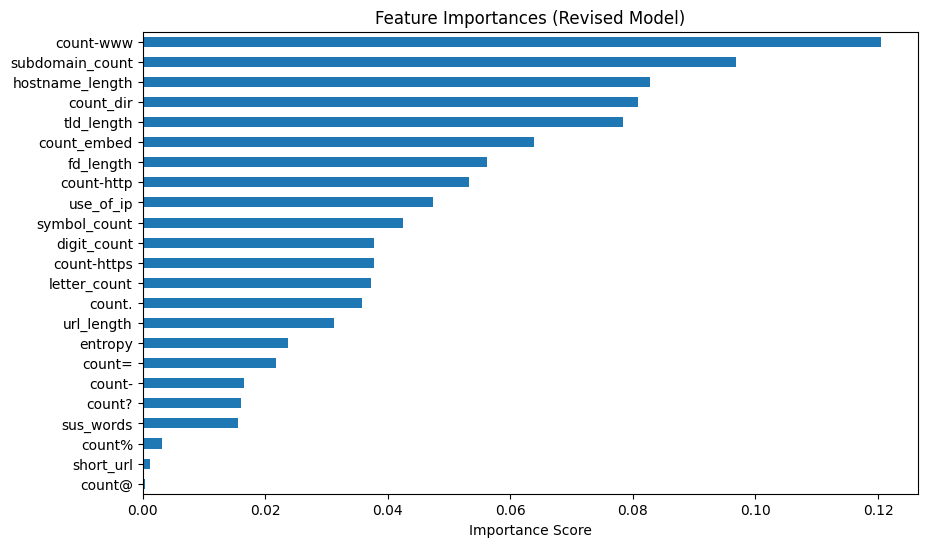

In [ ]:
# --- Environment Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import zipfile
from urllib.parse import urlparse
from tld import get_tld
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import joblib  # For model saving/loading
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

# --- Enhanced Feature Extraction ---
class URLFeatureExtractor:
    """
    Class to extract various features from a URL.
    """
    @staticmethod
    def having_ip_address(url):
        ip_pattern = re.compile(
            r'(\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b)|'
            r'(::\d{1,3})|'  # Simplified IPv6 check
            r'([0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}'
        )
        return 1 if ip_pattern.search(url) else 0

    @staticmethod
    def count_subdomains(url):
        parsed = urlparse(url)
        if parsed.netloc:
            return parsed.netloc.count('.')
        return 0

    @staticmethod
    def url_entropy(url):
        from math import log2
        if len(url) == 0:
            return 0
        unique_chars = set(url)
        probs = [float(url.count(c)) / len(url) for c in unique_chars]
        return -sum(p * log2(p) for p in probs)

    @staticmethod
    def extract_features(url):
        try:
            parsed = urlparse(url)
            features = {}

            # Basic features
            features['use_of_ip'] = URLFeatureExtractor.having_ip_address(url)
            features['count.'] = url.count('.')
            features['count-www'] = url.count('www')
            features['count@'] = url.count('@')
            features['count_dir'] = url.count('/')
            features['count_embed'] = url.count('//')
            features['short_url'] = 1 if any(s in url for s in ['bit.ly', 'goo.gl', 'tinyurl', 'ow.ly', 't.co']) else 0
            features['count-https'] = url.count('https')
            features['count-http'] = url.count('http')
            features['count%'] = url.count('%')
            features['count?'] = url.count('?')
            features['count-'] = url.count('-')
            features['count='] = url.count('=')
            features['url_length'] = len(url)
            features['hostname_length'] = len(parsed.netloc) if parsed.netloc else 0
            features['sus_words'] = 1 if re.search(r'login|signin|bank|account|update|free|secure|ebayisapi|webscr', url, re.I) else 0
            path_parts = parsed.path.split('/')
            features['fd_length'] = len(path_parts[1]) if len(path_parts) > 1 and path_parts[1] else 0
            tld_obj = get_tld(url, fail_silently=True, as_object=True)
            features['tld_length'] = len(tld_obj.domain) if tld_obj else 0

            # Advanced features
            features['subdomain_count'] = URLFeatureExtractor.count_subdomains(url)
            features['entropy'] = URLFeatureExtractor.url_entropy(url)
            features['digit_count'] = sum(c.isdigit() for c in url)
            features['letter_count'] = sum(c.isalpha() for c in url)
            features['symbol_count'] = len(url) - (features['digit_count'] + features['letter_count'])

            return pd.DataFrame([features])
        except Exception as e:
            print(f"Error processing {url}: {str(e)}")
            return pd.DataFrame()

# --- Revised Model Training with Feature Normalization ---
def train_model_revised():
    # Load data (ensure your CSV file 'malicious_phish.csv' exists)
    df = pd.read_csv('malicious_phish.csv')
    df = df[['url', 'type']].drop_duplicates().dropna()

    # Extract features
    feature_list = []
    for url in df['url']:
        feat_df = URLFeatureExtractor.extract_features(url)
        feature_list.append(feat_df)
    feature_df = pd.concat(feature_list, ignore_index=True)

    # Combine features with labels
    final_df = pd.concat([df.reset_index(drop=True), feature_df], axis=1)

    # Label encoding
    le = LabelEncoder()
    final_df['label'] = le.fit_transform(final_df['type'])

    # Use numeric features for training
    X = final_df.drop(['url', 'type', 'label'], axis=1)
    y = final_df['label']

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=SEED
    )

    # Compute class weights for imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Train RandomForest
    rf = RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        class_weight=weight_dict,
        random_state=SEED,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # Evaluate
    y_pred = rf.predict(X_test)
    print("Classification Report (Revised):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("Accuracy (Revised): {:.3f}".format(accuracy_score(y_test, y_pred)))

    # Save model, label encoder, and scaler
    joblib.dump(rf, 'url_classifier_revised.pkl')
    joblib.dump(le, 'label_encoder_revised.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print("Revised model, label encoder, and scaler saved.")

    return rf, le, scaler

# --- Revised Prediction System ---
class URLClassifierRevised:
    """
    Loads the revised RandomForest model, LabelEncoder, and scaler.
    Provides a method to predict the URL category.
    """
    def __init__(self):
        self.model = joblib.load('url_classifier_revised.pkl')
        self.le = joblib.load('label_encoder_revised.pkl')
        self.scaler = joblib.load('scaler.pkl')
        self.feature_columns = [
            'use_of_ip', 'count.', 'count-www', 'count@', 'count_dir',
            'count_embed', 'short_url', 'count-https', 'count-http',
            'count%', 'count?', 'count-', 'count=',
            'url_length', 'hostname_length', 'sus_words', 'fd_length',
            'tld_length', 'subdomain_count', 'entropy', 'digit_count',
            'letter_count', 'symbol_count'
        ]

    def predict(self, url):
        feat_df = URLFeatureExtractor.extract_features(url)
        if feat_df.empty:
            return "UNKNOWN"
        # Select expected features and fill missing values
        feat_df = feat_df[self.feature_columns].fillna(0)
        # Normalize the features
        X_scaled = self.scaler.transform(feat_df)
        pred = self.model.predict(X_scaled)
        return self.le.inverse_transform(pred)[0]


# --- Manual Testing ---
if __name__ == "__main__":
    # Train the model if not already done:
    if not os.path.exists('url_classifier_revised.pkl'):
        print("Training revised model...")
        train_model_revised()

    # Load classifier
    classifier = URLClassifierRevised()

    # Manual test URLs
    test_urls = [
        'http://www.google.com',
        'https://www.paypal-login.secure.com/update?account=123',
        'http://192.168.1.1:8080/path?query=1',
        'https://www.example.com'
    ]

    # Print features for debugging (optional)
    for url in test_urls:
        print(f"URL: {url}")
        features = URLFeatureExtractor.extract_features(url)
        print("Extracted Features:")
        print(features)
        prediction = classifier.predict(url)
        print(f"Prediction: {prediction}\n")

    # Optional: Plot feature importance
    model = classifier.model
    feat_importances = pd.Series(model.feature_importances_, index=classifier.feature_columns)
    feat_importances.sort_values().plot(kind="barh", figsize=(10, 6))
    plt.title("Feature Importances (Revised Model)")
    plt.xlabel("Importance Score")
    plt.show()


In [ ]:
!pip install tld

import pandas as pd
import joblib
import re
from urllib.parse import urlparse
from tld import get_tld  # Make sure to import get_tld

# Load the trained model and label encoder
model = joblib.load('url_classifier.pkl')  # Or the correct path to your saved model
le = joblib.load('label_encoder.pkl')  # Or the correct path to your saved label encoder

# Re-define extract_features (or ensure it's imported if it's in another file)
def extract_features(url):
    """Extract features from a single URL"""
    parsed = urlparse(url)
    features = {}

    # Basic features
    features['use_of_ip'] = 1 if re.search(r'(\d+\.\d+\.\d+\.\d+|:[0-9a-fA-F]+)', url) else 0
    features['count.'] = url.count('.')
    features['count-www'] = url.count('www')
    features['count@'] = url.count('@')
    features['count_dir'] = urlparse(url).path.count('/')
    features['count_embed'] = url.count('//')
    features['short_url'] = 1 if any(s in url for s in ['bit.ly', 'goo.gl', 'tinyurl', 'ow.ly', 't.co']) else 0  # Added 'ow.ly', 't.co'
    features['count-https'] = url.count('https')
    features['count-http'] = url.count('http')
    features['count%'] = url.count('%')
    features['count?'] = url.count('?')
    features['count-'] = url.count('-')
    features['count='] = url.count('=')
    features['url_length'] = len(url)
    features['hostname_length'] = len(parsed.netloc) if parsed.netloc else 0
    features['sus_words'] = 1 if re.search(r'login|signin|bank|account|update|free|secure|ebayisapi|webscr', url, re.I) else 0
    features['fd_length'] = len(parsed.path.split('/')[1]) if len(parsed.path.split('/')) > 1 else 0

    # Added tld extraction (if available)
    tld_obj = get_tld(url, fail_silently=True, as_object=True)
    features['tld_length'] = len(tld_obj.domain) if tld_obj else 0


    # Advanced features
    features['subdomain_count'] = parsed.netloc.count('.') if parsed.netloc else 0  # Ensure parsed.netloc exists

    # Ensure len(url) > 0 for entropy
    from math import log2
    if len(url) > 0:
        prob = [float(url.count(c)) / len(url) for c in set(url)]
        features['entropy'] = -sum(p * log2(p) for p in prob)
    else:
        features['entropy'] = 0  # Set entropy to 0 for empty url

    features['digit_count'] = sum(c.isdigit() for c in url)
    features['letter_count'] = sum(c.isalpha() for c in url)
    features['symbol_count'] = len(url) - (features['digit_count'] + features['letter_count'])

    return pd.DataFrame([features])

with open('/test_urls.txt') as f:
    urls = [line.strip() for line in f if line.strip()]

results = []
for url in urls:
    features = extract_features(url)
    pred = model.predict(features)[0]  # Assuming 'model' is loaded correctly
    results.append((url, le.inverse_transform([pred])[0]))  # Assuming 'le' is loaded correctly

pd.DataFrame(results, columns=['URL', 'Prediction']).to_csv('predictions.csv', index=False)

In [ ]:
import pandas as pd

# Load the predictions from the CSV file
results_df = pd.read_csv('predictions.csv')

# Print the DataFrame containing URLs and their predictions
print(results_df)


                                                 URL Prediction
0                       https://www.trusted-site.com   phishing
1                          http://malicious.ip/login   phishing
2                            https://fake-paypal.com   phishing
3  https://www.google.com/webhp?hl=en&sa=X&ved=0a...    malware


In [ ]:
probs = model.predict_proba(features)[0]
for class_name, prob in zip(le.classes_, probs):
    print(f"{class_name}: {prob:.2%}")

benign: 1.82%
defacement: 2.83%
malware: 5.03%
phishing: 90.33%


In [ ]:
print(features)

   use_of_ip  count.  count-www  count@  count_dir  count_embed  short_url  \
0          0       1          0       0          0            1          0   

   count-https  count-http  count%  ...  url_length  hostname_length  \
0            1           1       0  ...          23               15   

   sus_words  fd_length  tld_length  subdomain_count  entropy  digit_count  \
0          0          0          11                1  3.93618            0   

   letter_count  symbol_count  
0            18             5  

[1 rows x 23 columns]


In [ ]:
!rm -f optimized_rf_ensemble.pkl label_encoder_v4.pkl

In [ ]:
!rm -f optimized_rf_ensemble.pkl individual_models.pkl label_encoder_v4.pkl

In [ ]:
# --- Fix 1: Move EnsembleModel to top level ---
class EnsembleModel:
    """Top-level ensemble model that can be pickled"""
    def __init__(self, models=None):
        self.models = models or []

    def predict(self, X):
        preds = np.stack([m.predict(X) for m in self.models])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, preds)

# --- Fix 2: Modified training function ---
def train_optimized_model():
    # ... [previous chunk loading code remains the same until models list] ...

    # Create ensemble model with pickle-able class
    ensemble = EnsembleModel(models)

    # Save components separately
    joblib.dump(ensemble, 'optimized_rf_ensemble.pkl')
    joblib.dump(models, 'individual_models.pkl')  # Backup save
    joblib.dump(le, 'label_encoder_v4.pkl')

    return ensemble, le

# --- Fix 3: Updated classifier ---
class EfficientURLClassifier:
    def __init__(self):
        try:
            self.model = joblib.load('optimized_rf_ensemble.pkl')
            self.le = joblib.load('label_encoder_v4.pkl')
        except:
            # Fallback to loading individual models
            self.model = EnsembleModel(joblib.load('individual_models.pkl'))
            self.le = joblib.load('label_encoder_v4.pkl')

In [ ]:
!pip install tld

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import re
from urllib.parse import urlparse
from tld import get_tld
import os
import gc

SEED = 42
np.random.seed(SEED)

# --- Ultra-Efficient Feature Extraction ---
class URLFeatureExtractorV4:
    """Optimized feature extraction with minimal memory footprint"""

    @staticmethod
    def extract_features(df):
        try:
            features = pd.DataFrame(index=df.index)
            url_series = df['url'].astype('category')

            # IP detection using vectorized operations
            features['use_of_ip'] = url_series.str.contains(
                r'\b(?:\d{1,3}\.){3}\d{1,3}\b|:[0-9a-fA-F]{4}',
                regex=True, flags=re.IGNORECASE
            ).astype(np.int8)

            # URL structure features
            features['url_length'] = url_series.str.len().astype(np.int16)
            features['num_special_chars'] = url_series.str.count(r'[^\w.]').astype(np.int16)

            # TLD features with caching
            tld_cache = {}
            def get_cached_tld(x):
                if x not in tld_cache:
                    try:
                        tld_cache[x] = get_tld(x, fail_silently=True, as_object=True)
                    except Exception as e:
                        tld_cache[x] = None
                return tld_cache[x]

            features['is_suspicious_tld'] = url_series.apply(
                lambda x: 1 if (get_cached_tld(x) and get_cached_tld(x).tld in {'xyz', 'top', 'loan', 'win'}) else 0
            ).astype(np.int8)

            # Entropy calculation per URL
            from math import log2
            def entropy(x):
                if not x:
                    return 0.0
                counts = pd.Series(list(x)).value_counts(normalize=True)
                return -sum(counts * np.log2(counts))
            features['shannon_entropy'] = url_series.apply(entropy).astype(np.float32)

            # Pattern counts using regex
            patterns = {
                'num_slash': r'/',
                'num_dot': r'\.',
                'num_equal': r'=',
                'num_quest': r'\?'
            }
            for name, pattern in patterns.items():
                features[name] = url_series.str.count(pattern).astype(np.int8)

            return features

        except Exception as e:
            print(f"Feature extraction error: {str(e)}")
            return pd.DataFrame()

# --- Define EnsembleModel (outside the training function) ---
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        preds = np.stack([model.predict(X) for model in self.models])
        # Majority vote along axis 0
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, preds)

# --- Memory-Optimized Training ---
def train_optimized_model():
    # Fit the LabelEncoder on the full dataset's labels
    full_df = pd.read_csv('/new_data_urls.csv', usecols=['type'], dtype={'type': 'category'})
    le = LabelEncoder()
    le.fit(full_df['type'])

    # Process data in chunks
    chunks = pd.read_csv('malicious_phish.csv', chunksize=50000,
                         usecols=['url', 'type'],
                         dtype={'url': 'category', 'type': 'category'})

    chunk_models = []  # List to store models trained on each chunk

    for chunk in chunks:
        # Clean data
        chunk = chunk.drop_duplicates().dropna()
        if len(chunk) == 0:
            continue

        # Extract features for this chunk
        features = URLFeatureExtractorV4.extract_features(chunk)
        if features.empty or len(features) != len(chunk):
            print("Skipping chunk due to inconsistent feature extraction.")
            continue

        # Transform labels using the pre-fitted encoder
        labels = le.transform(chunk['type'])

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.2, random_state=SEED
        )

        # Train RandomForest on the chunk
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=12,
            n_jobs=-1,
            random_state=SEED
        )
        rf.fit(X_train, y_train)

        # Append the trained model to the list
        chunk_models.append(rf)

        # Cleanup to free memory
        del features, X_train, y_train
        gc.collect()

    # Create ensemble model that aggregates predictions from all chunk models
    ensemble = EnsembleModel(chunk_models)

    # Save the ensemble and label encoder
    with open('optimized_rf_ensemble.pkl', 'wb') as f:
        joblib.dump(ensemble, f, protocol=4, compress=3)
    with open('label_encoder_v4.pkl', 'wb') as f:
        joblib.dump(le, f, protocol=4, compress=3)

    print("Optimized ensemble model and label encoder saved.")
    return ensemble, le

# --- Prediction System ---
class EfficientURLClassifier:
    def __init__(self):
        self.model = joblib.load('optimized_rf_ensemble.pkl')
        self.le = joblib.load('label_encoder_v4.pkl')
        # Define feature columns (update as needed)
        self.feature_columns = [
            'use_of_ip', 'url_length', 'num_special_chars', 'is_suspicious_tld',
            'shannon_entropy', 'num_slash', 'num_dot', 'num_equal', 'num_quest'
        ]

    def predict(self, url):
        df_url = pd.DataFrame({'url': [url]})
        features = URLFeatureExtractorV4.extract_features(df_url)
        if features.empty:
            return "UNKNOWN"
        features = features[self.feature_columns].fillna(0)
        pred = self.model.predict(features)
        try:
            return self.le.inverse_transform(pred)[0]
        except ValueError:
            print(f"Warning: Unseen label encountered for URL: {url}")
            return "UNKNOWN"

# --- Execution ---
if __name__ == "__main__":
    if not os.path.exists('optimized_rf_ensemble.pkl'):
        print("Training optimized model...")
        train_optimized_model()

    classifier = EfficientURLClassifier()

    test_urls = [
        'https://www.trusted-bank.com/login',
        'http://192.168.1.1/.git/config',
        'https://paypal-security-alert.net/update',
        'https://www.google.com/search'
    ]

    for url in test_urls:
        print(f"URL: {url}")
        print(f"Prediction: {classifier.predict(url)}\n")


URL: https://www.trusted-bank.com/login
Prediction: phishing

URL: http://192.168.1.1/.git/config
Prediction: UNKNOWN

URL: https://paypal-security-alert.net/update
Prediction: phishing

URL: https://www.google.com/search
Prediction: UNKNOWN



In [ ]:
def predict(self, url):
    df_url = pd.DataFrame({'url': [url]})
    features = URLFeatureExtractorV4.extract_features(df_url)
    if features.empty:
        return "UNKNOWN"
    features = features[self.feature_columns].fillna(0)
    pred = self.model.predict(features)
    try:
        return self.le.inverse_transform(pred)[0]
    except ValueError:
        print(f"Warning: Unseen label encountered for URL: {url}")
        # Optionally, return a default value or re-map the predicted number
        return "UNKNOWN"


In [ ]:
df_full = pd.read_csv('malicious_phish.csv', usecols=['type'])
print("Unique labels in dataset:", df_full['type'].unique())


Unique labels in dataset: ['phishing' 'benign' 'defacement' 'malware']


In [ ]:
def predict(self, url):
    df_url = pd.DataFrame({'url': [url]})
    features = URLFeatureExtractorV4.extract_features(df_url)
    if features.empty:
        return "UNKNOWN"
    features = features[self.feature_columns].fillna(0)
    pred = self.model.predict(features)
    try:
        return self.le.inverse_transform(pred)[0]
    except ValueError:
        print(f"Warning: Unseen label encountered for URL: {url}")
        # Optionally, return a default value or re-map the predicted number
        return "UNKNOWN"


In [2]:
!pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.3 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import re
from urllib.parse import urlparse
from tld import get_tld
import os
import gc

SEED = 42
np.random.seed(SEED)

In [10]:
class URLFeatureExtractorV4:
    """Optimized feature extraction with minimal memory footprint"""

    @staticmethod
    def extract_features(df):
        try:
            features = pd.DataFrame(index=df.index)
            url_series = df['url'].astype('category')

            # IP detection using vectorized operations
            features['use_of_ip'] = url_series.str.contains(
                r'\b(?:\d{1,3}\.){3}\d{1,3}\b|:[0-9a-fA-F]{4}',
                regex=True, flags=re.IGNORECASE
            ).astype(np.int8)

            # URL structure features
            features['url_length'] = url_series.str.len().astype(np.int16)
            features['num_special_chars'] = url_series.str.count(r'[^\w.]').astype(np.int16)

            # TLD features with caching
            tld_cache = {}
            def get_cached_tld(x):
                if x not in tld_cache:
                    try:
                        tld_cache[x] = get_tld(x, fail_silently=True, as_object=True)
                    except Exception as e:
                        tld_cache[x] = None
                return tld_cache[x]

            features['is_suspicious_tld'] = url_series.apply(
                lambda x: 1 if (get_cached_tld(x) and get_cached_tld(x).tld in {'xyz', 'top', 'loan', 'win'}) else 0
            ).astype(np.int8)

            # Entropy calculation per URL
            from math import log2
            def entropy(x):
                if not x:
                    return 0.0
                counts = pd.Series(list(x)).value_counts(normalize=True)
                return -sum(counts * np.log2(counts))
            features['shannon_entropy'] = url_series.apply(entropy).astype(np.float32)

            # Pattern counts using regex
            patterns = {
                'num_slash': r'/',
                'num_dot': r'\.',
                'num_equal': r'=',
                'num_quest': r'\?'
            }
            for name, pattern in patterns.items():
                features[name] = url_series.str.count(pattern).astype(np.int8)

            return features

        except Exception as e:
            print(f"Feature extraction error: {str(e)}")
            return pd.DataFrame()

In [11]:
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        preds = np.stack([model.predict(X) for model in self.models])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, preds)

In [13]:
class URLFeatureExtractorV4:
    """Optimized feature extraction with minimal memory footprint"""

    @staticmethod
    def extract_features(df):
        try:
            features = pd.DataFrame(index=df.index)
            url_series = df['url'].astype('category')

            # IP detection using vectorized operations
            features['use_of_ip'] = url_series.str.contains(
                r'\b(?:\d{1,3}\.){3}\d{1,3}\b|:[0-9a-fA-F]{4}',
                regex=True, flags=re.IGNORECASE
            ).astype(np.int8)

            # URL structure features
            features['url_length'] = url_series.str.len().astype(np.int16)
            features['num_special_chars'] = url_series.str.count(r'[^\w.]').astype(np.int16)

            # TLD features with caching
            tld_cache = {}
            def get_cached_tld(x):
                if x not in tld_cache:
                    try:
                        tld_cache[x] = get_tld(x, fail_silently=True, as_object=True)
                    except Exception as e:
                        tld_cache[x] = None
                return tld_cache[x]

            features['is_suspicious_tld'] = url_series.apply(
                lambda x: 1 if (get_cached_tld(x) and get_cached_tld(x).tld in {'xyz', 'top', 'loan', 'win'}) else 0
            ).astype(np.int8)

            # Entropy calculation per URL
            from math import log2
            def entropy(x):
                if not x:
                    return 0.0
                counts = pd.Series(list(x)).value_counts(normalize=True)
                return -sum(counts * np.log2(counts))
            features['shannon_entropy'] = url_series.apply(entropy).astype(np.float32)

            # Pattern counts using regex
            patterns = {
                'num_slash': r'/',
                'num_dot': r'\.',
                'num_equal': r'=',
                'num_quest': r'\?'
            }
            for name, pattern in patterns.items():
                features[name] = url_series.str.count(pattern).astype(np.int8)

            return features

        except Exception as e:
            print(f"Feature extraction error: {str(e)}")
            return pd.DataFrame()

In [14]:
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        preds = np.stack([model.predict(X) for model in self.models])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, preds)

In [12]:
def train_optimized_model():
    # Fit LabelEncoder on full dataset's labels
    full_df = pd.read_csv('/content/new_data_urls.csv', usecols=['type'], dtype={'type': 'category'})
    le = LabelEncoder()
    le.fit(full_df['type'])

    # Process data in chunks
    chunks = pd.read_csv('/content/malicious_phish.csv', chunksize=50000,
                         usecols=['url', 'type'],
                         dtype={'url': 'category', 'type': 'category'})

    chunk_models = []

    for chunk in chunks:
        chunk = chunk.drop_duplicates().dropna()
        if len(chunk) == 0:
            continue

        features = URLFeatureExtractorV4.extract_features(chunk)
        if features.empty or len(features) != len(chunk):
            print("Skipping chunk due to inconsistent feature extraction.")
            continue

        labels = le.transform(chunk['type'])
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.2, random_state=SEED
        )

        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=12,
            n_jobs=-1,
            random_state=SEED
        )
        rf.fit(X_train, y_train)
        chunk_models.append(rf)

        del features, X_train, y_train
        gc.collect()

    ensemble = EnsembleModel(chunk_models)

    with open('optimized_rf_ensemble.pkl', 'wb') as f:
        joblib.dump(ensemble, f, protocol=4, compress=3)
    with open('label_encoder_v4.pkl', 'wb') as f:
        joblib.dump(le, f, protocol=4, compress=3)

    print("Optimized ensemble model and label encoder saved.")
    return ensemble, le

In [15]:
class EfficientURLClassifier:
    def __init__(self):
        self.model = joblib.load('optimized_rf_ensemble.pkl')
        self.le = joblib.load('label_encoder_v4.pkl')
        self.feature_columns = [
            'use_of_ip', 'url_length', 'num_special_chars', 'is_suspicious_tld',
            'shannon_entropy', 'num_slash', 'num_dot', 'num_equal', 'num_quest'
        ]

    def predict(self, url):
        df_url = pd.DataFrame({'url': [url]})
        features = URLFeatureExtractorV4.extract_features(df_url)
        if features.empty:
            return "UNKNOWN"
        features = features[self.feature_columns].fillna(0)
        pred = self.model.predict(features)
        try:
            return self.le.inverse_transform(pred)[0]
        except ValueError:
            print(f"Warning: Unseen label encountered for URL: {url}")
            return "UNKNOWN"

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import re
from urllib.parse import urlparse
from tld import get_tld
import os
import gc

SEED = 42
np.random.seed(SEED)

# --- Ultra-Efficient Feature Extraction ---
class URLFeatureExtractorV4:
    """Optimized feature extraction with minimal memory footprint"""
    @staticmethod
    def extract_features(df):
        try:
            features = pd.DataFrame(index=df.index)
            url_series = df['url'].astype('category')

            features['use_of_ip'] = url_series.str.contains(
                r'\b(?:\d{1,3}\.){3}\d{1,3}\b|:[0-9a-fA-F]{4}',
                regex=True, flags=re.IGNORECASE
            ).fillna(0).astype(np.int8)

            features['url_length'] = url_series.str.len().astype(np.int16)
            features['num_special_chars'] = url_series.str.count(r'[^\w.]').astype(np.int16)

            tld_cache = {}
            def get_cached_tld(x):
                if x not in tld_cache:
                    try:
                        tld_cache[x] = get_tld(x, fail_silently=True, as_object=True)
                    except Exception as e:
                        tld_cache[x] = None
                return tld_cache[x]

            features['is_suspicious_tld'] = url_series.apply(
                lambda x: 1 if (get_cached_tld(x) and get_cached_tld(x).tld in {'xyz', 'top', 'loan', 'win'}) else 0
            ).astype(np.int8)

            from math import log2
            def entropy(x):
                if not x:
                    return 0.0
                counts = pd.Series(list(x)).value_counts(normalize=True)
                return -sum(counts * np.log2(counts))
            features['shannon_entropy'] = url_series.apply(entropy).astype(np.float32)

            patterns = {
                'num_slash': r'/',
                'num_dot': r'\.',
                'num_equal': r'=',
                'num_quest': r'\?'
            }
            for name, pattern in patterns.items():
                features[name] = url_series.str.count(pattern).astype(np.int8)

            return features

        except Exception as e:
            print(f"Feature extraction error: {str(e)}")
            return pd.DataFrame()

# --- Define EnsembleModel ---
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        preds = np.stack([model.predict(X) for model in self.models])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, preds)

# --- Memory-Optimized Training ---
def train_optimized_model(data_path='malicious_phish.csv'):
    # Check if file exists and has required columns
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found: {data_path}")

    # Read a small sample to check columns
    sample_df = pd.read_csv(data_path, nrows=5)
    required_cols = ['url', 'type']
    missing_cols = [col for col in required_cols if col not in sample_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in {data_path}: {missing_cols}")

    # Fit LabelEncoder on full dataset's labels
    full_df = pd.read_csv(data_path, usecols=['type'], dtype={'type': 'category'})
    le = LabelEncoder()
    le.fit(full_df['type'])

    # Process data in chunks
    chunks = pd.read_csv(data_path, chunksize=50000,
                         usecols=['url', 'type'],
                         dtype={'url': 'category', 'type': 'category'})

    chunk_models = []

    for chunk in chunks:
        chunk = chunk.drop_duplicates().dropna()
        if len(chunk) == 0:
            continue

        features = URLFeatureExtractorV4.extract_features(chunk)
        if features.empty or len(features) != len(chunk):
            print("Skipping chunk due to inconsistent feature extraction.")
            continue

        labels = le.transform(chunk['type'])
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.2, random_state=SEED
        )

        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=12,
            n_jobs=-1,
            random_state=SEED
        )
        rf.fit(X_train, y_train)
        chunk_models.append(rf)

        del features, X_train, y_train
        gc.collect()

    if not chunk_models:
        raise ValueError("No models were trained - check data or feature extraction")

    ensemble = EnsembleModel(chunk_models)

    with open('optimized_rf_ensemble.pkl', 'wb') as f:
        joblib.dump(ensemble, f, protocol=4, compress=3)
    with open('label_encoder_v4.pkl', 'wb') as f:
        joblib.dump(le, f, protocol=4, compress=3)

    print("Optimized ensemble model and label encoder saved.")
    return ensemble, le

# --- Prediction System ---
class EfficientURLClassifier:
    def __init__(self):
        self.model = joblib.load('optimized_rf_ensemble.pkl')
        self.le = joblib.load('label_encoder_v4.pkl')
        self.feature_columns = [
            'use_of_ip', 'url_length', 'num_special_chars', 'is_suspicious_tld',
            'shannon_entropy', 'num_slash', 'num_dot', 'num_equal', 'num_quest'
        ]

    def predict(self, url):
        df_url = pd.DataFrame({'url': [url]})
        features = URLFeatureExtractorV4.extract_features(df_url)
        if features.empty:
            return "UNKNOWN"
        features = features[self.feature_columns].fillna(0)
        pred = self.model.predict(features)
        try:
            return self.le.inverse_transform(pred)[0]
        except ValueError:
            print(f"Warning: Unseen label encountered for URL: {url}")
            return "UNKNOWN"

# --- Execution ---
if __name__ == "__main__":
    try:
        if not os.path.exists('optimized_rf_ensemble.pkl'):
            print("Training optimized model...")
            train_optimized_model()  # Use default 'malicious_phish.csv'

        classifier = EfficientURLClassifier()

        test_urls = [
            'https://www.trusted-bank.com/login',
            'http://192.168.1.1/.git/config',
            'https://paypal-security-alert.net/update',
            'https://www.google.com/search'
        ]

        for url in test_urls:
            print(f"URL: {url}")
            print(f"Prediction: {classifier.predict(url)}\n")

    except Exception as e:
        print(f"Error during execution: {str(e)}")

Training optimized model...
Optimized ensemble model and label encoder saved.
URL: https://www.trusted-bank.com/login
Prediction: benign

URL: http://192.168.1.1/.git/config
Prediction: defacement

URL: https://paypal-security-alert.net/update
Prediction: benign

URL: https://www.google.com/search
Prediction: defacement



In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import re
from urllib.parse import urlparse
from tld import get_tld
import os
import gc

SEED = 42
np.random.seed(SEED)

# --- Enhanced Feature Extraction ---
class URLFeatureExtractorV5:
    """Enhanced feature extraction with more discriminative features"""
    @staticmethod
    def extract_features(df):
        try:
            features = pd.DataFrame(index=df.index)
            url_series = df['url'].astype(str)  # Ensure string type

            # IP and protocol features
            features['use_of_ip'] = url_series.str.contains(
                r'\b(?:\d{1,3}\.){3}\d{1,3}\b|:[0-9a-fA-F]{4}',
                regex=True, flags=re.IGNORECASE
            ).fillna(0).astype(np.int8)
            features['has_https'] = url_series.str.startswith('https').astype(np.int8)

            # URL structure features
            features['url_length'] = url_series.str.len().astype(np.int16)
            features['num_special_chars'] = url_series.str.count(r'[^\w.]').astype(np.int16)
            features['num_digits'] = url_series.str.count(r'\d').astype(np.int16)

            # TLD features
            tld_cache = {}
            def get_cached_tld(x):
                if x not in tld_cache:
                    try:
                        tld_cache[x] = get_tld(x, fail_silently=True, as_object=True)
                    except:
                        tld_cache[x] = None
                return tld_cache[x]

            features['tld_length'] = url_series.apply(
                lambda x: len(get_cached_tld(x).tld) if get_cached_tld(x) else 0
            ).astype(np.int8)
            features['is_suspicious_tld'] = url_series.apply(
                lambda x: 1 if (get_cached_tld(x) and get_cached_tld(x).tld in {'xyz', 'top', 'loan', 'win', 'club'}) else 0
            ).astype(np.int8)

            # Domain features
            features['subdomain_count'] = url_series.apply(
                lambda x: urlparse(x).netloc.count('.') if urlparse(x).netloc else 0
            ).astype(np.int8)

            # Entropy
            from math import log2
            def entropy(x):
                if not x:
                    return 0.0
                counts = pd.Series(list(x)).value_counts(normalize=True)
                return -sum(counts * np.log2(counts))
            features['shannon_entropy'] = url_series.apply(entropy).astype(np.float32)

            # Pattern counts
            patterns = {
                'num_slash': r'/',
                'num_dot': r'\.',
                'num_equal': r'=',
                'num_quest': r'\?',
                'num_hyphen': r'-',
                'num_at': r'@'
            }
            for name, pattern in patterns.items():
                features[name] = url_series.str.count(pattern).astype(np.int8)

            # Suspicious keywords
            features['has_suspicious_words'] = url_series.str.contains(
                r'login|signin|bank|account|update|secure|paypal|verify',
                case=False
            ).fillna(0).astype(np.int8)

            return features

        except Exception as e:
            print(f"Feature extraction error: {str(e)}")
            return pd.DataFrame()

# --- Ensemble Model ---
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        preds = np.stack([model.predict(X) for model in self.models])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, preds)

    def predict_proba(self, X):
        probas = np.mean([model.predict_proba(X) for model in self.models], axis=0)
        return probas

# --- Training Function ---
def train_optimized_model(data_path='malicious_phish.csv'):
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found: {data_path}")

    sample_df = pd.read_csv(data_path, nrows=5)
    required_cols = ['url', 'type']
    missing_cols = [col for col in required_cols if col not in sample_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    full_df = pd.read_csv(data_path, usecols=['type'], dtype={'type': 'category'})
    le = LabelEncoder()
    le.fit(full_df['type'])

    chunks = pd.read_csv(data_path, chunksize=50000,
                         usecols=['url', 'type'],
                         dtype={'url': str, 'type': 'category'})

    chunk_models = []
    for i, chunk in enumerate(chunks):
        chunk = chunk.drop_duplicates().dropna()
        if len(chunk) == 0:
            continue

        features = URLFeatureExtractorV5.extract_features(chunk)
        if features.empty or len(features) != len(chunk):
            print(f"Skipping chunk {i} due to inconsistent feature extraction")
            continue

        labels = le.transform(chunk['type'])
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.2, random_state=SEED
        )

        rf = RandomForestClassifier(
            n_estimators=100,  # Increased for better learning
            max_depth=15,      # Increased for more complexity
            n_jobs=-1,
            random_state=SEED,
            class_weight='balanced'  # Handle imbalance
        )
        rf.fit(X_train, y_train)

        # Evaluate on test set
        y_pred = rf.predict(X_test)
        print(f"\nChunk {i} Classification Report:")
        print(classification_report(y_train, rf.predict(X_train), target_names=le.classes_))

        chunk_models.append(rf)
        del features, X_train, y_train
        gc.collect()

    if not chunk_models:
        raise ValueError("No models trained - check data")

    ensemble = EnsembleModel(chunk_models)
    joblib.dump(ensemble, 'optimized_rf_ensemble.pkl', protocol=4, compress=3)
    joblib.dump(le, 'label_encoder_v5.pkl', protocol=4, compress=3)
    print("Optimized ensemble model and label encoder saved.")
    return ensemble, le

# --- Prediction System ---
class EfficientURLClassifier:
    def __init__(self):
        self.model = joblib.load('optimized_rf_ensemble.pkl')
        self.le = joblib.load('label_encoder_v5.pkl')
        self.feature_columns = [
            'use_of_ip', 'has_https', 'url_length', 'num_special_chars', 'num_digits',
            'tld_length', 'is_suspicious_tld', 'subdomain_count', 'shannon_entropy',
            'num_slash', 'num_dot', 'num_equal', 'num_quest', 'num_hyphen', 'num_at',
            'has_suspicious_words'
        ]

    def predict(self, url):
        df_url = pd.DataFrame({'url': [url]})
        features = URLFeatureExtractorV5.extract_features(df_url)
        if features.empty:
            return "UNKNOWN"

        features = features[self.feature_columns].fillna(0)
        pred = self.model.predict(features)
        proba = self.model.predict_proba(features)[0]

        try:
            prediction = self.le.inverse_transform(pred)[0]
            print(f"\nURL: {url}")
            print(f"Prediction: {prediction}")
            print("Probabilities:")
            for class_name, prob in zip(self.le.classes_, proba):
                print(f"{class_name}: {prob:.2%}")
            return prediction
        except ValueError as e:
            print(f"Warning: Unseen label encountered for URL: {url} - {str(e)}")
            return "UNKNOWN"

# --- Execution ---
if __name__ == "__main__":
    try:
        if not os.path.exists('optimized_rf_ensemble.pkl'):
            print("Training optimized model...")
            train_optimized_model()

        classifier = EfficientURLClassifier()
        test_urls = [
            'https://www.trusted-bank.com/login',
            'http://192.168.1.1/.git/config',
            'https://paypal-security-alert.net/update',
            'https://www.google.com/search'
        ]

        for url in test_urls:
            classifier.predict(url)

    except Exception as e:
        print(f"Error during execution: {str(e)}")

Error during execution: [Errno 2] No such file or directory: 'label_encoder_v5.pkl'


In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import re
from urllib.parse import urlparse
from tld import get_tld
import os
import gc

SEED = 42
np.random.seed(SEED)

# --- Enhanced Feature Extraction ---
class URLFeatureExtractorV5:
    """Enhanced feature extraction with more discriminative features"""
    @staticmethod
    def extract_features(df):
        try:
            features = pd.DataFrame(index=df.index)
            url_series = df['url'].astype(str)

            features['use_of_ip'] = url_series.str.contains(
                r'\b(?:\d{1,3}\.){3}\d{1,3}\b|:[0-9a-fA-F]{4}',
                regex=True, flags=re.IGNORECASE
            ).fillna(0).astype(np.int8)
            features['has_https'] = url_series.str.startswith('https').astype(np.int8)

            features['url_length'] = url_series.str.len().astype(np.int16)
            features['num_special_chars'] = url_series.str.count(r'[^\w.]').astype(np.int16)
            features['num_digits'] = url_series.str.count(r'\d').astype(np.int16)

            tld_cache = {}
            def get_cached_tld(x):
                if x not in tld_cache:
                    try:
                        tld_cache[x] = get_tld(x, fail_silently=True, as_object=True)
                    except:
                        tld_cache[x] = None
                return tld_cache[x]

            features['tld_length'] = url_series.apply(
                lambda x: len(get_cached_tld(x).tld) if get_cached_tld(x) else 0
            ).astype(np.int8)
            features['is_suspicious_tld'] = url_series.apply(
                lambda x: 1 if (get_cached_tld(x) and get_cached_tld(x).tld in {'xyz', 'top', 'loan', 'win', 'club'}) else 0
            ).astype(np.int8)

            features['subdomain_count'] = url_series.apply(
                lambda x: urlparse(x).netloc.count('.') if urlparse(x).netloc else 0
            ).astype(np.int8)

            from math import log2
            def entropy(x):
                if not x:
                    return 0.0
                counts = pd.Series(list(x)).value_counts(normalize=True)
                return -sum(counts * np.log2(counts))
            features['shannon_entropy'] = url_series.apply(entropy).astype(np.float32)

            patterns = {
                'num_slash': r'/',
                'num_dot': r'\.',
                'num_equal': r'=',
                'num_quest': r'\?',
                'num_hyphen': r'-',
                'num_at': r'@'
            }
            for name, pattern in patterns.items():
                features[name] = url_series.str.count(pattern).astype(np.int8)

            features['has_suspicious_words'] = url_series.str.contains(
                r'login|signin|bank|account|update|secure|paypal|verify',
                case=False
            ).fillna(0).astype(np.int8)

            return features

        except Exception as e:
            print(f"Feature extraction error: {str(e)}")
            return pd.DataFrame()

# --- Ensemble Model ---
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        preds = np.stack([model.predict(X) for model in self.models])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, preds)

    def predict_proba(self, X):
        probas = np.mean([model.predict_proba(X) for model in self.models], axis=0)
        return probas

# --- Training Function ---
def train_optimized_model(data_path='malicious_phish.csv'):
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found: {data_path}")

    sample_df = pd.read_csv(data_path, nrows=5)
    required_cols = ['url', 'type']
    missing_cols = [col for col in required_cols if col not in sample_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    full_df = pd.read_csv(data_path, usecols=['type'], dtype={'type': 'category'})
    le = LabelEncoder()
    le.fit(full_df['type'])

    chunks = pd.read_csv(data_path, chunksize=50000,
                         usecols=['url', 'type'],
                         dtype={'url': str, 'type': 'category'})

    chunk_models = []
    for i, chunk in enumerate(chunks):
        chunk = chunk.drop_duplicates().dropna()
        if len(chunk) == 0:
            continue

        features = URLFeatureExtractorV5.extract_features(chunk)
        if features.empty or len(features) != len(chunk):
            print(f"Skipping chunk {i} due to inconsistent feature extraction")
            continue

        labels = le.transform(chunk['type'])
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.2, random_state=SEED
        )

        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            n_jobs=-1,
            random_state=SEED,
            class_weight='balanced'
        )
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)
        print(f"\nChunk {i} Classification Report:")
        print(classification_report(y_test, y_pred, target_names=le.classes_))

        chunk_models.append(rf)
        del features, X_train, y_train
        gc.collect()

    if not chunk_models:
        raise ValueError("No models trained - check data")

    ensemble = EnsembleModel(chunk_models)
    joblib.dump(ensemble, 'optimized_rf_ensemble.pkl', protocol=4, compress=3)
    joblib.dump(le, 'label_encoder_v5.pkl', protocol=4, compress=3)
    print("Optimized ensemble model and label encoder saved.")
    return ensemble, le

# --- Prediction System ---
class EfficientURLClassifier:
    def __init__(self):
        model_file = 'optimized_rf_ensemble.pkl'
        label_file = 'label_encoder_v5.pkl'
        if not (os.path.exists(model_file) and os.path.exists(label_file)):
            raise FileNotFoundError(f"Required model files missing: {model_file} and/or {label_file}")

        self.model = joblib.load(model_file)
        self.le = joblib.load(label_file)
        self.feature_columns = [
            'use_of_ip', 'has_https', 'url_length', 'num_special_chars', 'num_digits',
            'tld_length', 'is_suspicious_tld', 'subdomain_count', 'shannon_entropy',
            'num_slash', 'num_dot', 'num_equal', 'num_quest', 'num_hyphen', 'num_at',
            'has_suspicious_words'
        ]

    def predict(self, url):
        df_url = pd.DataFrame({'url': [url]})
        features = URLFeatureExtractorV5.extract_features(df_url)
        if features.empty:
            return "UNKNOWN"

        features = features[self.feature_columns].fillna(0)
        pred = self.model.predict(features)
        proba = self.model.predict_proba(features)[0]

        try:
            prediction = self.le.inverse_transform(pred)[0]
            print(f"\nURL: {url}")
            print(f"Prediction: {prediction}")
            print("Probabilities:")
            for class_name, prob in zip(self.le.classes_, proba):
                print(f"{class_name}: {prob:.2%}")
            return prediction
        except ValueError as e:
            print(f"Warning: Unseen label encountered for URL: {url} - {str(e)}")
            return "UNKNOWN"

# --- Execution ---
if __name__ == "__main__":
    try:
        model_file = 'optimized_rf_ensemble.pkl'
        label_file = 'label_encoder_v5.pkl'

        # Check if both files exist, train if either is missing
        if not (os.path.exists(model_file) and os.path.exists(label_file)):
            print("Training optimized model...")
            train_optimized_model()

        classifier = EfficientURLClassifier()
        test_urls = [
            'https://www.trusted-bank.com/login',
            'http://192.168.1.1/.git/config',
            'https://paypal-security-alert.net/update',
            'https://www.google.com/search'
        ]

        for url in test_urls:
            classifier.predict(url)

    except Exception as e:
        print(f"Error during execution: {str(e)}")

Training optimized model...

Chunk 0 Classification Report:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      7350
  defacement       0.96      0.98      0.97      1841
     malware       0.78      0.67      0.72       153
    phishing       0.95      0.90      0.92       573

    accuracy                           0.98      9917
   macro avg       0.92      0.89      0.90      9917
weighted avg       0.98      0.98      0.98      9917


Chunk 1 Classification Report:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      7272
  defacement       0.96      0.97      0.97      1898
     malware       0.81      0.68      0.74       161
    phishing       0.93      0.91      0.92       579

    accuracy                           0.98      9910
   macro avg       0.92      0.89      0.91      9910
weighted avg       0.98      0.98      0.98      9910


Chunk 2 Classification Report:
      